In [2]:
import os
import sys

sys.path.append(os.path.abspath(os.path.dirname(os.path.dirname(os.path.join(os.getcwd())))))

import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from data_utils.utils import keep_existing_photos, downsample_group, show_images
from data_utils.dataset import PhotoLabelDataset, stratified_split_dataset, val_transform
from model.resnet18 import Resnet18FineTuneModel
from model.utils import get_device
from model.gradcam import display_grad_cam, display_target_image_grad_cam

### Binary prediction model single modality

In [3]:
base_dir = "../../"

business_df = pd.read_json(f'{base_dir}data/yelp_dataset/yelp_academic_dataset_business.json', lines=True)
photos_df = pd.read_json(f'{base_dir}data/yelp_photos/photos.json', lines=True)
top_reviews_per_restaurant = pd.read_csv(f'{base_dir}data/yelp_dataset/top_reviews_per_restaurant_with_summary.csv')

photo_dir = f"{base_dir}data/yelp_photos/resized_photos"
photos_df = keep_existing_photos(photos_df, photo_dir)

photos_df = photos_df[photos_df['label'] == 'food'].copy()

categories_df = business_df[['business_id', 'attributes']].copy()
photos_df = photos_df.merge(categories_df, on="business_id", how="left")

photos_df = photos_df[photos_df['attributes'].notna()]
photos_df['price_range'] = photos_df['attributes'].apply(lambda x: x.get('RestaurantsPriceRange2'))

photos_df['price_range'] = photos_df['price_range'].astype(int)
photos_df['price_range'] = photos_df['price_range'].replace({2: 1, 3: 2, 4: 2}) 

food_with_reviews_df = photos_df.merge(top_reviews_per_restaurant, on="business_id", how="left")

Checking images: 100%|██████████| 200100/200100 [00:08<00:00, 23917.24it/s]


In [4]:
price_2_num = (photos_df.price_range == 2).sum()

food_df = photos_df.groupby('price_range', group_keys=False).apply(
    lambda x: downsample_group(x, price_2_num) if x.name in [1] else x
)

food_df['price_range'] = food_df['price_range'] - 1

/var/folders/6n/sm2tfzkn2hjd8cpfn_256ph00000gp/T/ipykernel_68532/102111114.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  food_df = photos_df.groupby('price_range', group_keys=False).apply(


In [5]:
label = 'price_range'

price_dataset = PhotoLabelDataset(food_df, photo_dir, label)
labels = food_df[label].values 
train_size = 0.85
val_size = 0.10

_, _, test_dataset = stratified_split_dataset(
    price_dataset,
    labels,
    train_size=train_size,
    val_size=val_size,
    random_state=42
)

test_dataset.transform = val_transform

batch_size = 64

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

In [85]:
num_classes = 2
device = get_device()

binary_image_only = Resnet18FineTuneModel(num_classes=num_classes)

ckpt = torch.load(f"{base_dir}saved_models/price_binary/ckpt_20")
binary_image_only.load_state_dict(ckpt['model_state_dict'])
binary_image_only.to(device)
binary_image_only.eval()

Resnet18FineTuneModel(
  (base): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [86]:
all_class_0 = []
all_class_1 = []
all_conf = []
seen_images = set() 

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)

        outputs = binary_image_only(images)
        probs = F.softmax(outputs, dim=1)

        max_conf, pred_classes = torch.max(probs, dim=1)

        for i in range(len(images)):
            conf = max_conf[i].item()
            pred_class = pred_classes[i].item()
            img_tuple = tuple(images[i].cpu().numpy().flatten())

            if img_tuple in seen_images:
                continue
            seen_images.add(img_tuple)
            
            sample = (conf, images[i])

            if pred_class == 0:
                all_class_0.append(sample)
            elif pred_class == 1:
                all_class_1.append(sample)

            all_conf.append(sample)

In [87]:
# Sort by confidence
top_5_class_0 = sorted(all_class_0, key=lambda x: x[0], reverse=True)[:5]
top_5_class_1 = sorted(all_class_1, key=lambda x: x[0], reverse=True)[:5]
bottom_5_class_0 = sorted(all_class_0, key=lambda x: x[0], reverse=True)[-5::]
bottom_5_class_1 = sorted(all_class_1, key=lambda x: x[0], reverse=True)[-5::]
bottom_5_conf = sorted(all_conf, key=lambda x: x[0])[:5]

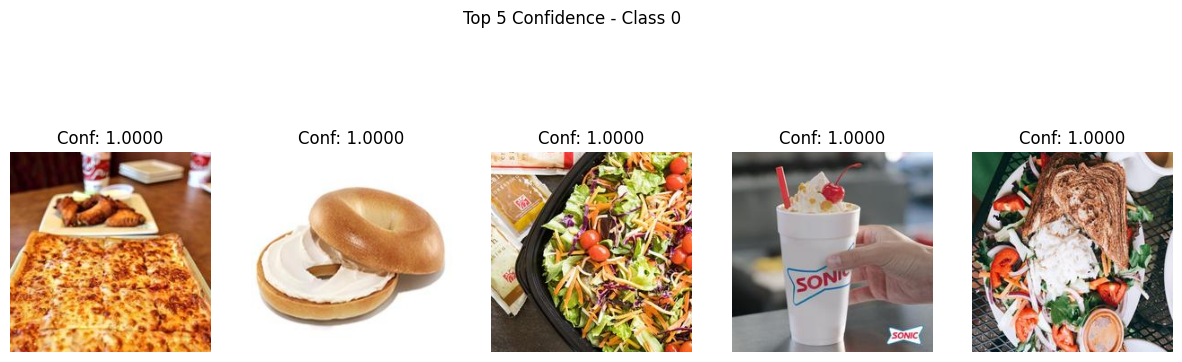

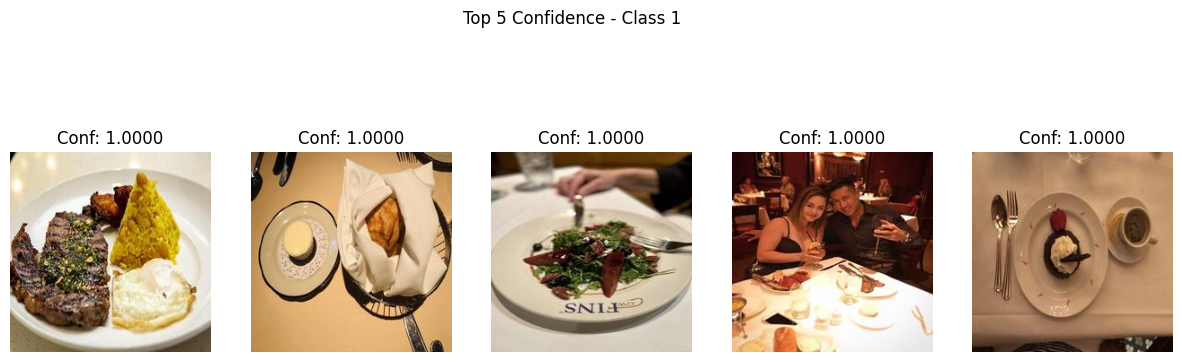

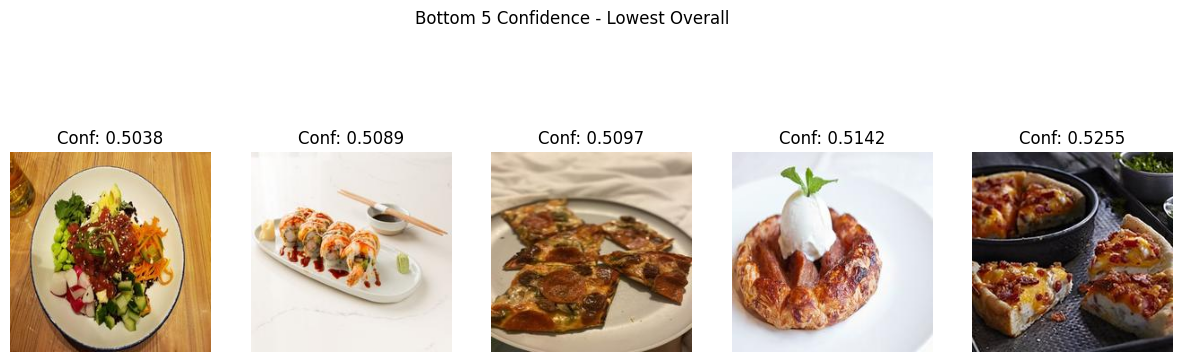

In [88]:
if top_5_class_0:
    show_images(top_5_class_0, "Top 5 Confidence - Class 0")
if top_5_class_1:
    show_images(top_5_class_1, "Top 5 Confidence - Class 1")
if bottom_5_conf:
    show_images(bottom_5_conf, "Bottom 5 Confidence - Lowest Overall")

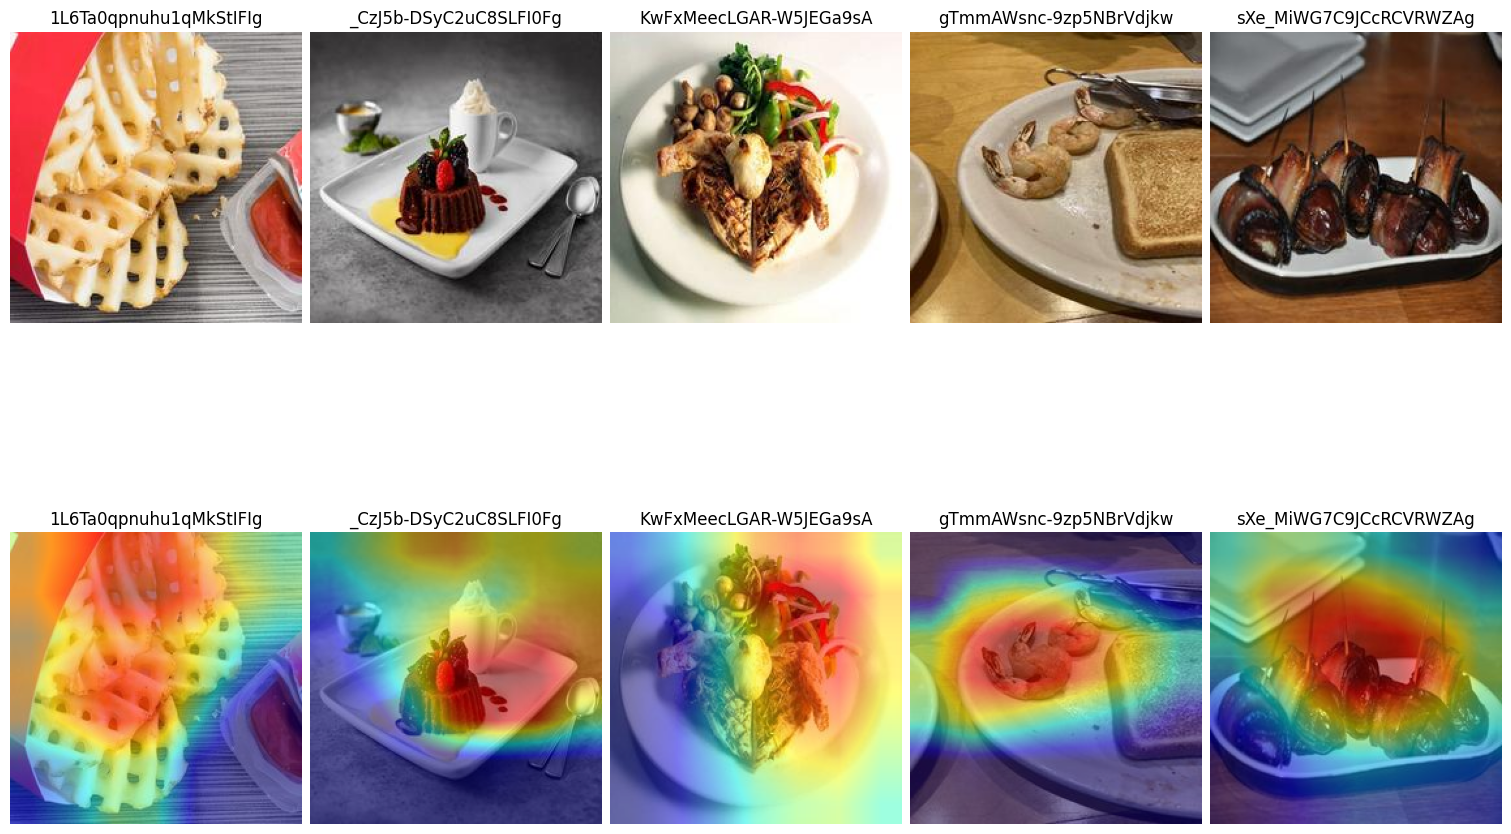

In [89]:
photo_ids = set(food_df.photo_id.unique())
display_grad_cam(binary_image_only, device, photo_ids, photo_dir, num_images=5)

### Display examples of food and grad-cam

In [113]:
top_confidence_class_0_examples = top_5_class_0[1:3]
top_confidence_class_1_examples = top_5_class_1[0:2]
bottom_confidence_class_0_examples = [bottom_5_class_0[2], bottom_5_class_0[4]]
bottom_confidence_class_1_examples = [bottom_5_class_1[1], bottom_5_class_1[3]]

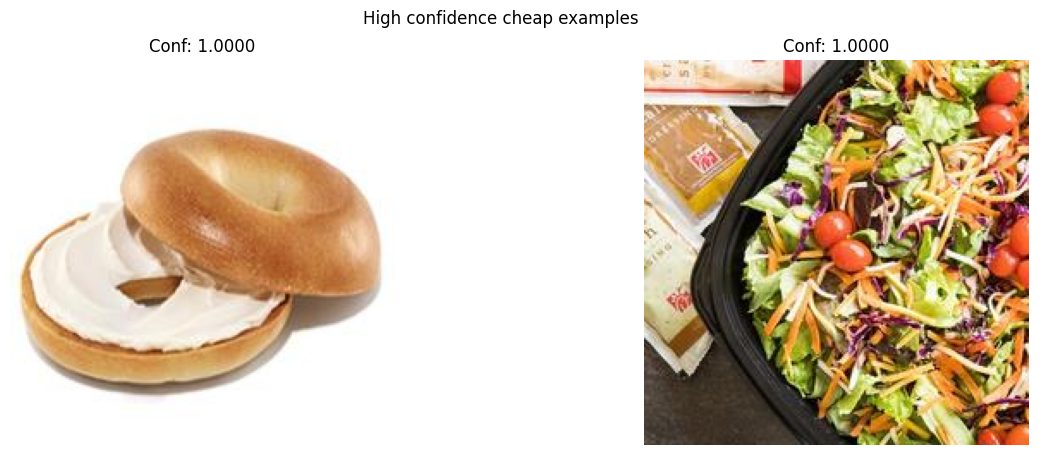

/Users/ericxia/Library/Caches/pypoetry/virtualenvs/food-classification-nES7ttkF-py3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


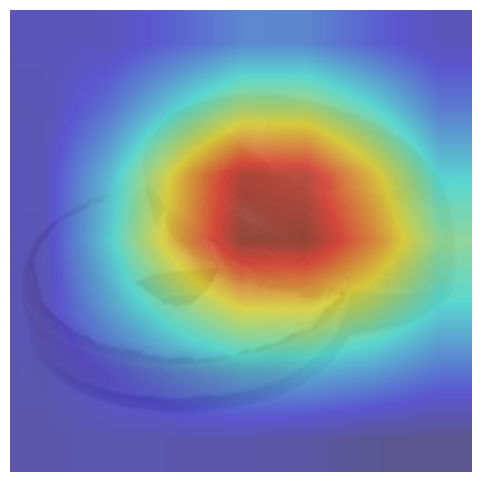

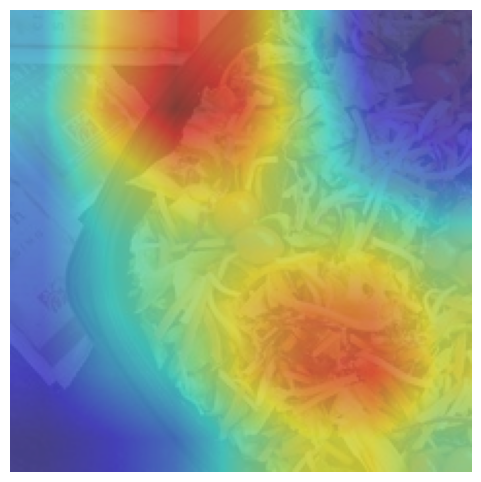

In [99]:
show_images(top_confidence_class_0_examples, "High confidence cheap examples")
display_target_image_grad_cam(binary_image_only, device, top_confidence_class_0_examples[0][1])
display_target_image_grad_cam(binary_image_only, device, top_confidence_class_0_examples[1][1])

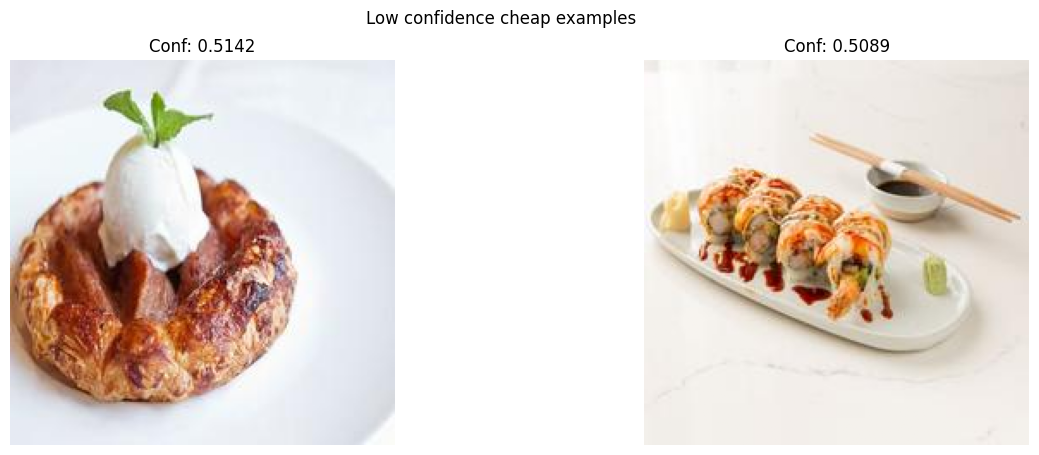

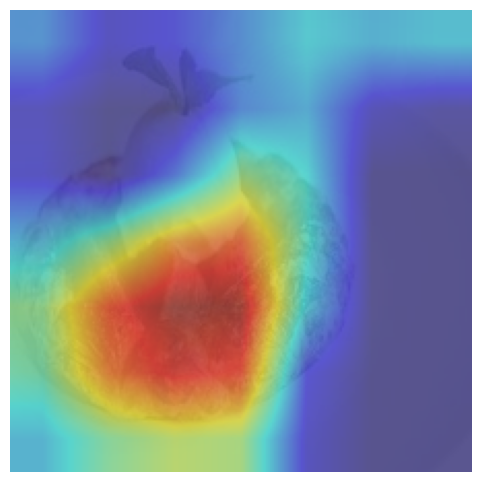

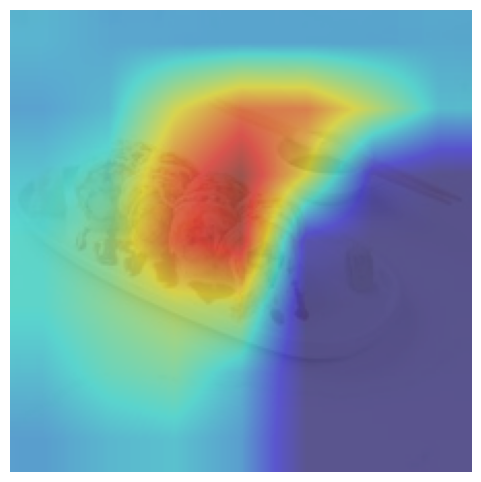

In [100]:
show_images(bottom_confidence_class_0_examples, "Low confidence cheap examples")
display_target_image_grad_cam(binary_image_only, device, bottom_confidence_class_0_examples[0][1])
display_target_image_grad_cam(binary_image_only, device, bottom_confidence_class_0_examples[1][1])

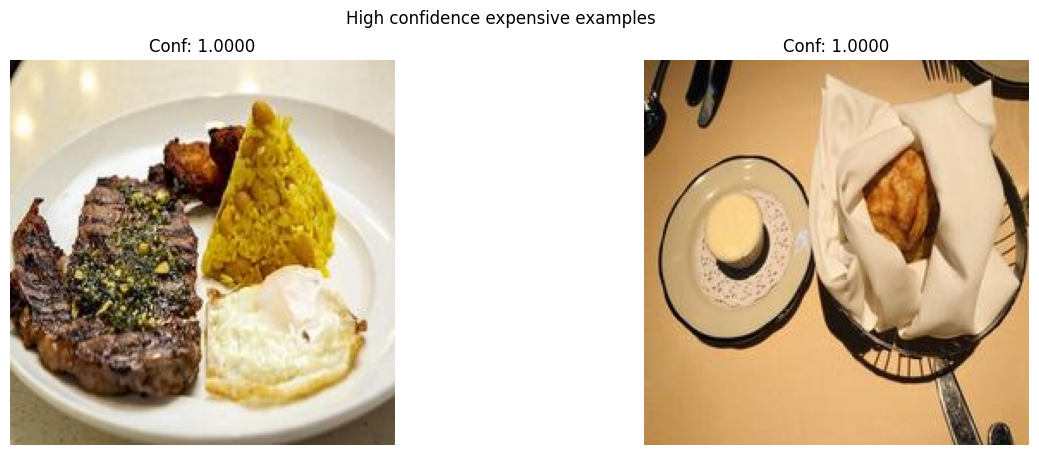

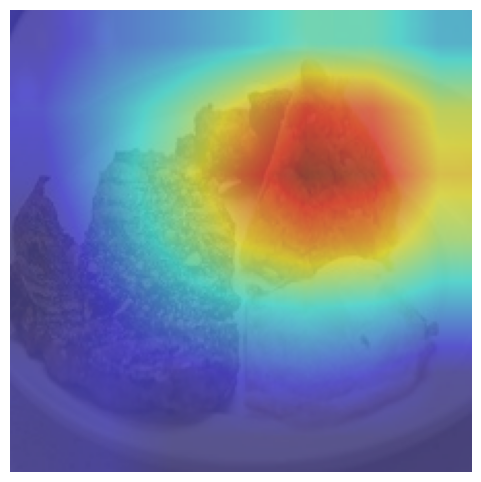

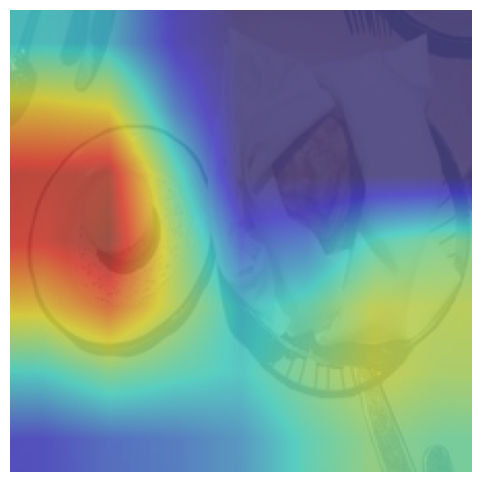

In [101]:
show_images(top_confidence_class_1_examples, "High confidence expensive examples")
display_target_image_grad_cam(binary_image_only, device, top_confidence_class_1_examples[0][1])
display_target_image_grad_cam(binary_image_only, device, top_confidence_class_1_examples[1][1])

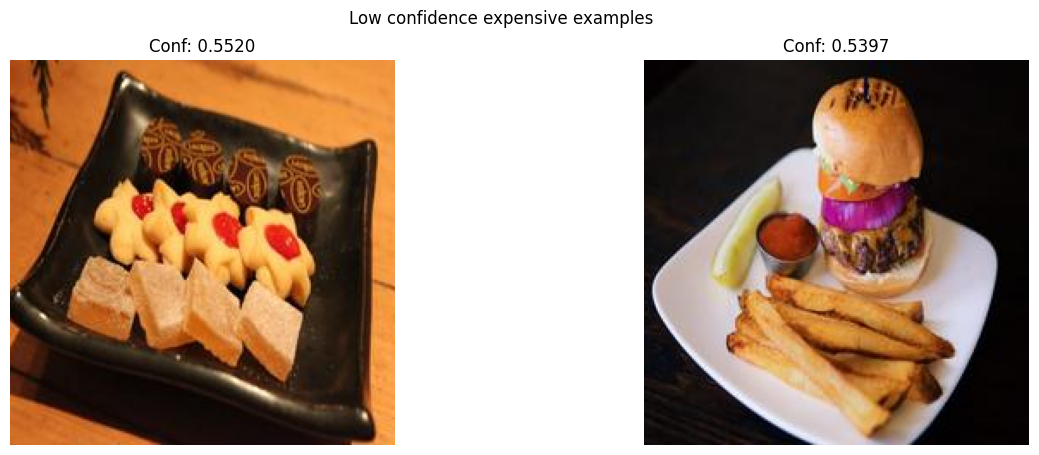

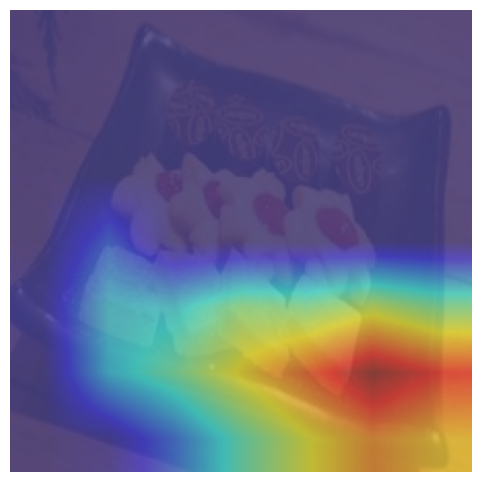

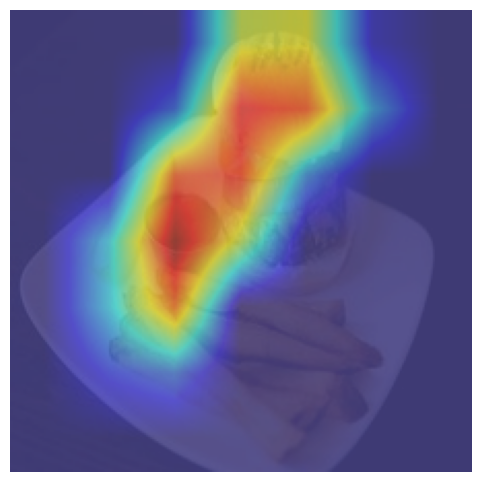

In [114]:
show_images(bottom_confidence_class_1_examples, "Low confidence expensive examples")
display_target_image_grad_cam(binary_image_only, device, bottom_confidence_class_1_examples[0][1])
display_target_image_grad_cam(binary_image_only, device, bottom_confidence_class_1_examples[1][1])